# Assignment 3
The task of the assignment #3 is the design of a CNN architecture and its training.

Input dataset: MNIST digits (input size 28x28x1, number of classes: 10).
The dataset is not distributed since can be easily downloaded directly from Keras.
Please consider the original dataset partition into trainig-valid-test (no other splits or cross-validation are needed).

The CNN has to be designed with the hard constraint of a maximum of 7.5K parameters.

The report must contain:
- a description of the designed architecture
- the parameters count for each layer
- the hyper-parameters used for training (batch size, learning rate, optimizer, number of epochs, etc)
- a plot of the training and validation loss/accuracy 
- classification performance on training, validation (if available) and test sets

In [170]:
!pip install keras-metrics

import keras
import keras_metrics
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
from google.colab import drive
from matplotlib import pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.layers import Dense, Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
import random

%matplotlib inline

## Carico e ridimensiono i dati MNIST

Carico i dati mnist direttamente con la funzione di keras

In [171]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


I dati nella suddetta forma NON SONO ADATTI alla rete convoluzionale per keras: ho infatti bisogno di avere una dimensione in più: uso la funzione np.expand_dim sul train e sul test set dando un asse in più (3 al posto che 2)

La dimensione in più rappresenta il canale dei grigi (non essendo a colori non necessito dei 3 canali RGB)

*altezza x larghezza x canali*

In [172]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


Ora i miei dati sono della dimensione giusta.

Vediamoli:

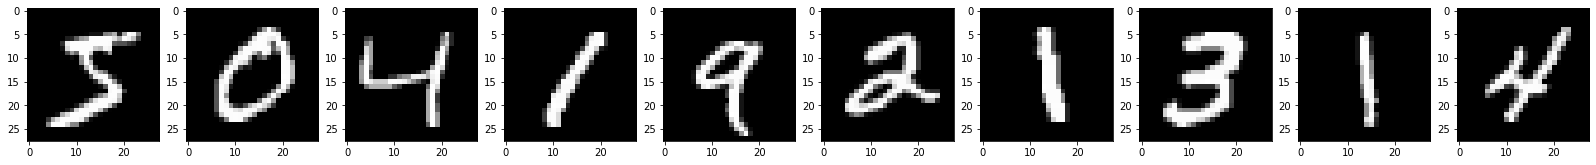

In [173]:
n = 10
plt.figure(figsize=(28, 28))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()

Essendo immagini in scala di grigi:

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

## Costruisco il modello

In [175]:
#filters num, filters dimension

model = Sequential()
model.add(Conv2D(filters=9, kernel_size=6, input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=7, kernel_size=6))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(47, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],)
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 23, 23, 9)         333       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 11, 11, 9)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 6, 6, 7)           2275      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 3, 3, 7)           0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 63)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 47)                3008      
_________________________________________________________________
dropout_28 (Dropout)         (None, 47)              

Ho esattamente 7,482 parametri che sono sotto il massimo consentito di 7,500

## Learning del modello sui dati di train e validation

In [176]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1) #Imposto che le epoche si fermino quando val_loss smette di migliorare 

history=model.fit(x_train, to_categorical(y_train), epochs=50, validation_split=0.20, callbacks=[early_stop], batch_size=200) #validation impostato a 20% del traning

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 4s 86us/step - loss: 0.9782 - acc: 0.6782 - val_loss: 0.2649 - val_acc: 0.9248
Epoch 2/50
48000/48000 [==============================] - 3s 53us/step - loss: 0.3772 - acc: 0.8881 - val_loss: 0.1771 - val_acc: 0.9482
Epoch 3/50
48000/48000 [==============================] - 3s 53us/step - loss: 0.2846 - acc: 0.9164 - val_loss: 0.1402 - val_acc: 0.9569
Epoch 4/50
48000/48000 [==============================] - 3s 52us/step - loss: 0.2221 - acc: 0.9354 - val_loss: 0.1162 - val_acc: 0.9654
Epoch 5/50
48000/48000 [==============================] - 3s 53us/step - loss: 0.1924 - acc: 0.9442 - val_loss: 0.1042 - val_acc: 0.9681
Epoch 6/50
48000/48000 [==============================] - 3s 52us/step - loss: 0.1717 - acc: 0.9502 - val_loss: 0.1032 - val_acc: 0.9698
Epoch 7/50
48000/48000 [==============================] - 3s 52us/step - loss: 0.1547 - acc: 0.9552 - val_loss: 0.0887 - val_acc

### Performance

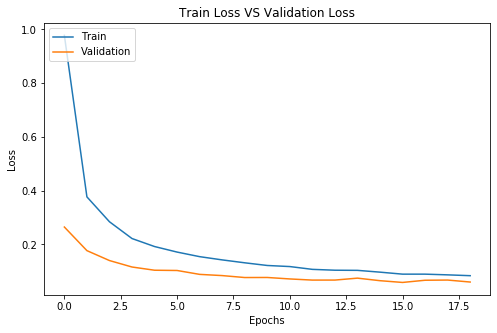

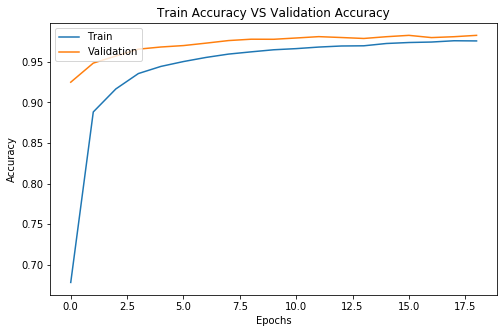

In [177]:
def plot_train_vs_validate_loss(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title("Train Loss VS Validation Loss")
    plt.show()

def plot_train_vs_validate_acc(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title("Train Accuracy VS Validation Accuracy")
    plt.show()
    
plot_train_vs_validate_loss(history)
plot_train_vs_validate_acc(history)


## Predizione sul Test Set

In [0]:
predictions = model.predict(x_test)

Prima di vedere le performance effettiva, confrontando le label del test set, provo a stampare le immagini del test con "PRED: x" sopra, dove X è quello che il mio modello pensa che sia la lettera sottostante.

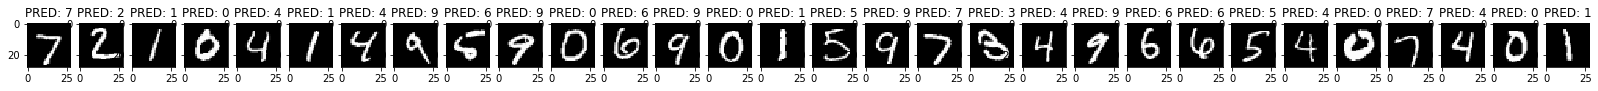

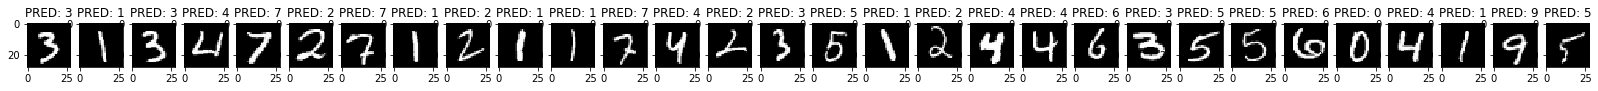

In [179]:
n = 30
plt.figure(figsize=(28, 28))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    ax.set_title("PRED: %s" %(np.argmax(predictions[i])))
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    
n = 60
plt.figure(figsize=(28, 28))
for i in range(30, n):
    ax = plt.subplot(2, n-30, i + 1)
    ax.set_title("PRED: %s" %(np.argmax(predictions[i])))
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
  

Il risultato sembra essere a occhio soddisfacente.
Vediamo effetticamente a quanto ammonta l'accuracy e la loss sul test set

In [180]:
results = model.evaluate(x_test, to_categorical(y_test), batch_size=256)
print('test loss:', results[0])
print('test accuracy:', results[1])

10000/10000 [==============================] - 0s 18us/step
test loss: 0.052822817125718576
test accuracy: 0.9853


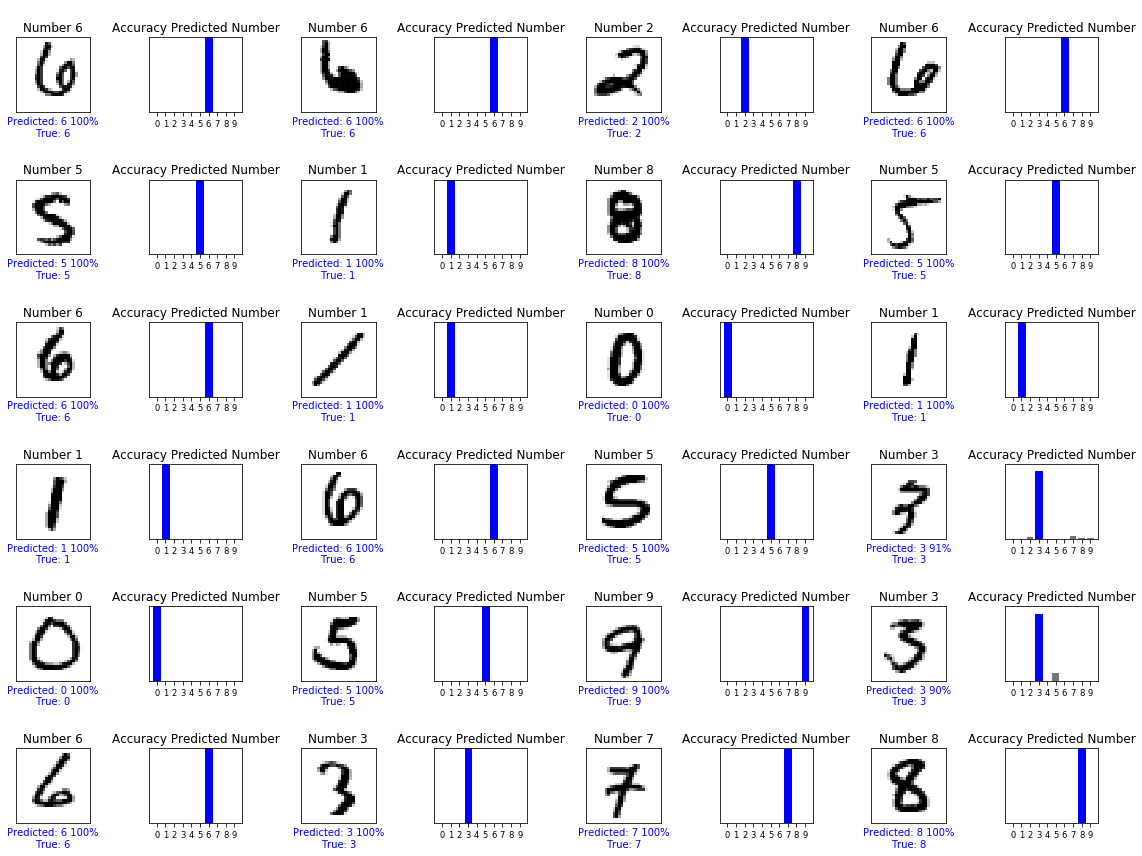

In [181]:
import random as rand

# plot validation images with their predicted label, probability of the prediction and barplot
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = img.reshape(img.shape[:-1])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)

    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.title("\nNumber {}".format(true_label))
    plt.xlabel("Predicted: {} {:2.0f}%\nTrue: {}".format(predicted_label,
                                    100*np.max(predictions_array),
                                    true_label),
                                    color=color)

# display barplot with prediction probability
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10), range(10), size='small')
    plt.yticks([])
    plt.title("Accuracy Predicted Number")
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_label)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
def plot_predicted_letter(predictions, X_val, Y_val):
    num_rows = 6
    num_cols = 4
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))

    for i in range(num_images):
        rand_sample_idx = rand.randrange(len(predictions))
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(rand_sample_idx, predictions[rand_sample_idx], Y_val, X_val)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(rand_sample_idx, predictions[rand_sample_idx],  Y_val)
    plt.tight_layout()
    plt.show()



plot_predicted_letter(predictions, x_test, to_categorical(y_test))